# Building Custom Datasets in PyTorch

PyTorch provides popular datasets through its dataset API. These datasets can be loaded with a few lines of code. In addition, PyTorch also provides mechanisms to load and wrap custom data as PyTorch datasets. We'll learn to create PyTorch datasets with custom data in this exercise. We'll broadly cover the following topics:

- [Data Preparation](#data-preparation)
  - [Procurement](#procurement)
  - [Dataset Creation Using ImageFolder](#dataset-creation-using-imagefolder)
  - [Dataset Creation with a Custom Dataset](#dataset-creation-with-a-custom-dataset)
- [TinyVGG Model](#tinyvgg-without-data-augmentation)
- [TinyVGG Model](#tinyvgg-with-data-augmentation)

We'll follow the [PyTorch Custom Dataset](https://www.learnpytorch.io/04_pytorch_custom_datasets/) tutorial by [@mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning)

# Import Modules

In [169]:
import random
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchinfo import summary as model_summary
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
from PIL import Image
from typing import Tuple, Dict, List

print(f'Torch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')

Torch Version: 2.1.0.dev20230608
Torchvision Version: 0.16.0.dev20230608


# Configuration

In [149]:
SEED = 3
IMG_SIZE = 64

# Device Selection

In [3]:
DEVICE = 'cpu'

if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'

print(f'Device: {DEVICE}')

Device: mps


# Data Preparation

## Procurement

We will download the [Food101](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) dataset.

In [29]:
import requests
import zipfile

# Setup path to data folder
data_path = Path(os.path.expanduser("~/.datasets/"))
image_path = data_path / "pizza_steak_sushi"
train_path = image_path / 'train'
test_path = image_path / 'test'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

/Users/broxoli/.datasets/pizza_steak_sushi directory exists.


### Exploration

In [30]:
import os

def summarize_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        if len(dirnames) != 0:
            print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        else:
            print(f"There are {len(filenames)} images in '{dirpath}'.")

print('Training Set')
print('------------')
summarize_dir(train_path)

print('\nTest Set')
print('------------')
summarize_dir(test_path)

Training Set
------------
There are 3 directories and 0 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train'.
There are 75 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/steak'.
There are 72 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/sushi'.
There are 78 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/pizza'.

Test Set
------------
There are 3 directories and 0 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test'.
There are 19 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/steak'.
There are 31 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/sushi'.
There are 25 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/pizza'.


### Visualization

Path: /Users/broxoli/.datasets/pizza_steak_sushi/train/pizza/218711.jpg
Class: pizza
Size: 512 x 382


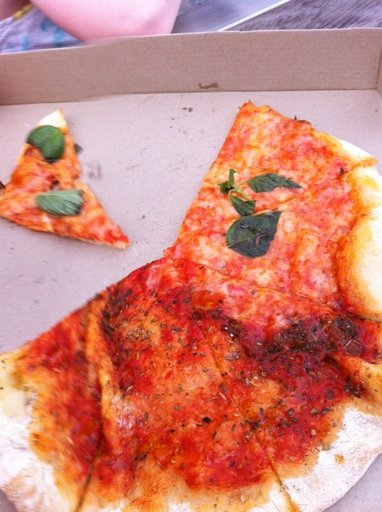

In [49]:
random.seed(SEED)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open the random image
image = Image.open(random_image_path)

# 5. Print metadata
print(f"Path: {random_image_path}")
print(f"Class: {image_class}")
print(f"Size: {image.height} x {image.width}") 

display(image)

## Dataset Creation Using ImageFolder

### Transformations

#### Composition

We apply the following transformations:
- Resize input image to 64x64.
- Random horizontal flips.
- Convert input to tensors.

In [51]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

#### Visualization

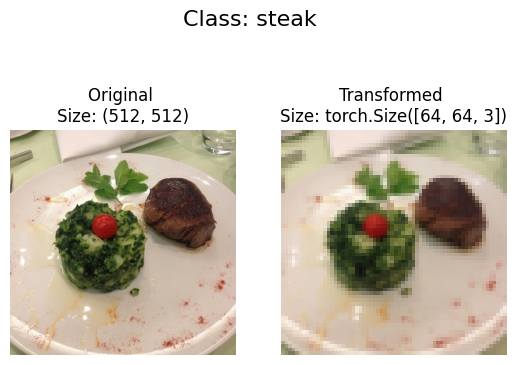

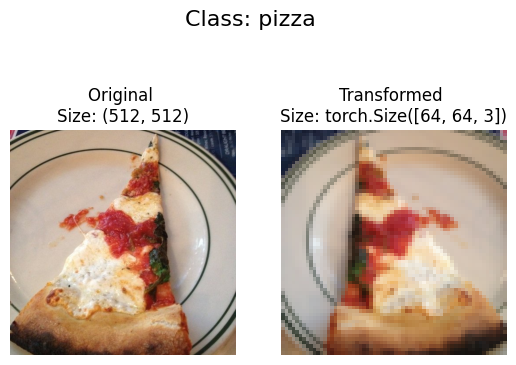

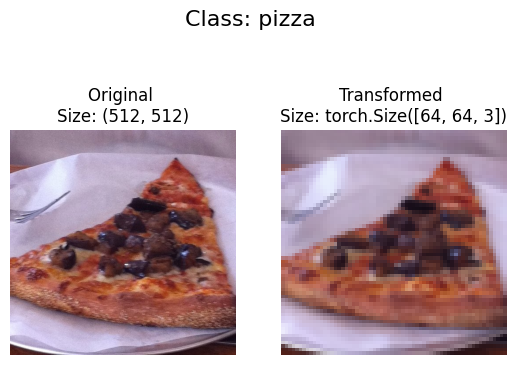

In [134]:
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

random.seed(SEED)

plot_transformed_images(image_path_list, transform=data_transform)

### Dataset Creation

In [78]:
train_data = datasets.ImageFolder(root=train_path, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

class_names = train_data.classes
class_dict = train_data.class_to_idx

print('Training Set')
print('------------')
print(f'{train_data}')
print(f'Classes: {train_data.classes}')
print(f'Class Dictionary: {train_data.class_to_idx}')

print('\nTest Set')
print('------------')
print(f'{test_data}')
print(f'Classes: {test_data.classes}')
print(f'Class Dictionary: {test_data.class_to_idx}')

Training Set
------------
Dataset ImageFolder
    Number of datapoints: 225
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}

Test Set
------------
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


#### Exploration

In [72]:
image, label = train_data[0]

print('Image')
print('-----')
print(f'Shape: {image.shape} Type: {image.dtype}')

print('\nLabel')
print('------')
print(f'Label: {label} ({class_names[label]}) Type: {type(label).__name__}')

Image
-----
Shape: torch.Size([3, 64, 64]) Type: torch.float32

Label
------
Label: 0 (pizza) Type: int


#### Visualization

Original shape: torch.Size([3, 64, 64]) -> [channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, channels]


Text(0.5, 1.0, 'pizza')

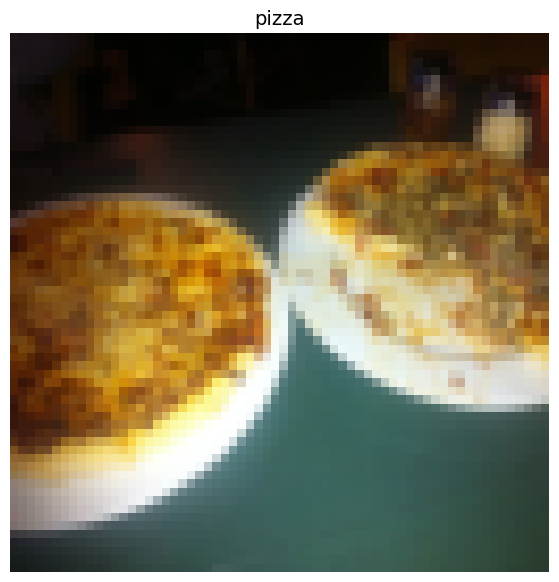

In [74]:
image_permute = image.permute(1, 2, 0)

print(f"Original shape: {image.shape} -> [channels, height, width]")
print(f"Permuted shape: {image_permute.shape} -> [height, width, channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(image_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### DataLoader

#### Creation

In [137]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=1, 
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1, 
    shuffle=True
)

print('Train DataLoader')
print('----------------')
print(f'{train_dataloader}')

print('\nTest DataLoader')
print('----------------')
print(f'{test_dataloader}')

Train DataLoader
----------------

Test DataLoader
----------------


#### Exploration

In [77]:
image, label = next(iter(train_dataloader))

print('Image')
print('-----')
print(f'Shape: {image.shape} Type: {image.dtype}')

print('\nLabel')
print('------')
print(f'Label: {label} ({class_names[label]}) Type: {label.dtype}')

Image
-----
Shape: torch.Size([1, 3, 64, 64]) Type: torch.float32

Label
------
Label: tensor([0]) (pizza) Type: torch.int64


## Dataset Creation with a Custom Dataset

### Discover Classes

In [91]:
def discover_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

train_classes, train_class_to_idx = discover_classes(train_path)
test_classes, test_class_to_idx = discover_classes(test_path)

print('\nTraining Classes')
print('------------------')
print(f'Classes: {train_classes}')
print(f'Class Dictionary: {train_class_to_idx}')

print('\nTest Classes')
print('------------------')
print(f'Classes: {test_classes}')
print(f'Class Dictionary: {test_class_to_idx}')


Training Classes
------------------
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}

Test Classes
------------------
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


### Custom Dataset Definition

In [94]:
# 1. Subclass torch.utils.data.Dataset
class CustomImageFolder(Dataset):
    # 2. Initialize with a target_dir and transform (optional) parameter
    def __init__(self, target_dir: str, transform=None) -> None:
        # 3. Get all image paths
        self.image_paths = list(Path(target_dir).glob('*/*.jpg'))

        # 4. Setup Transforms
        self.transform = transform

        # 5. Discover Classes
        self.classes, self.class_to_idx = discover_classes(target_directory)
    
    # 6. Create a function to load an image given its path
    def load_image(self, index: int) -> Image.Image:
        image_path = self.image_paths[index]
        return Image.open(image_path)

    # 7. Override __len__() method with our custom implementation.
    def __len__(self) -> int:
        return len(self.image_paths)
    
    # 8. Override __getitem__() method with our custom implementation.
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns a sample of (image tensor, label)
        """
        image = self.load_image(index)
        class_name = self.image_paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # 9. Apply Transformations
        image = self.transform(image) if self.transform else image

        return image, class_idx

### Transformations

We apply the following transformations:
- Resize input image to 64x64.
- Random horizontal flips. It is applied only to the training set.
- Convert input to tensors.

#### Creation

In [132]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

#### Visualization

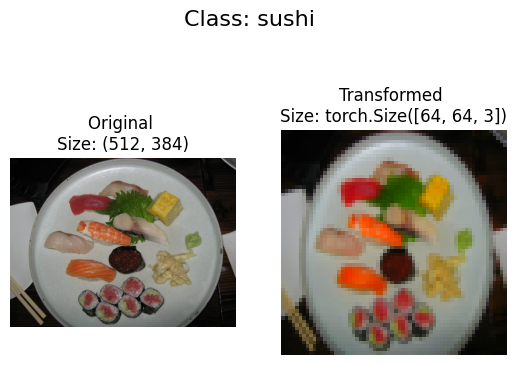

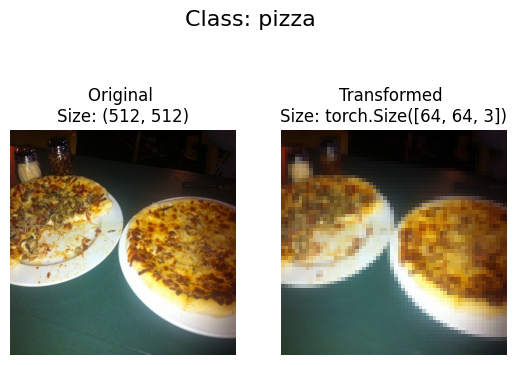

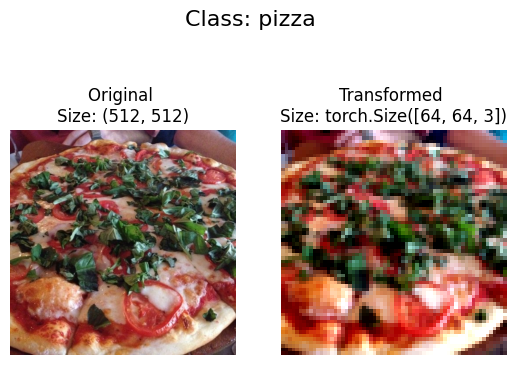

In [135]:
plot_transformed_images(image_path_list, transform=train_transforms)

### Dataset Creation

In [130]:
train_data_custom = CustomImageFolder(target_dir=train_dir, transform=train_transforms)
test_data_custom = CustomImageFolder(target_dir=test_dir, transform=test_transforms)

class_names = train_data_custom.classes
class_dict = train_data_custom.class_to_idx

print('Training Set')
print('------------')
print(f'{train_data_custom}')
print(f'Classes: {train_data_custom.classes}')
print(f'Class Dictionary: {train_data_custom.class_to_idx}')
print(f'Size: {len(train_data_custom)}')

print('\nTest Set')
print('------------')
print(f'{test_data_custom}')
print(f'Classes: {test_data_custom.classes}')
print(f'Class Dictionary: {test_data_custom.class_to_idx}')
print(f'Size: {len(test_data_custom)}')

Training Set
------------
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}
Size: 225

Test Set
------------
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}
Size: 75


#### Visualization

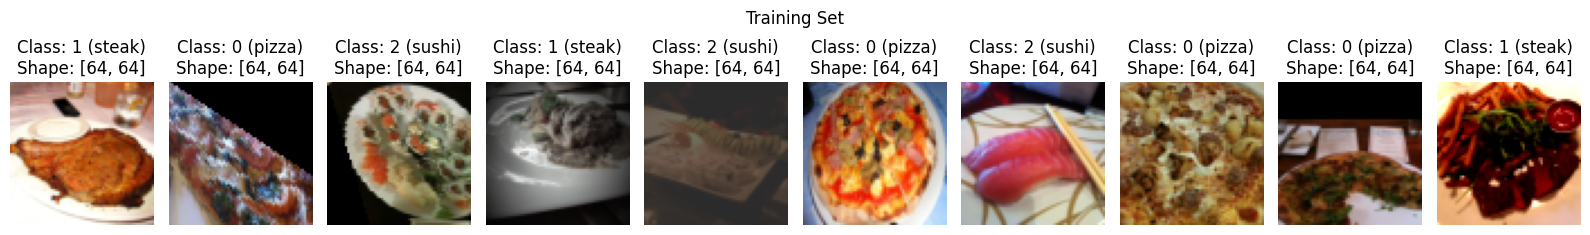

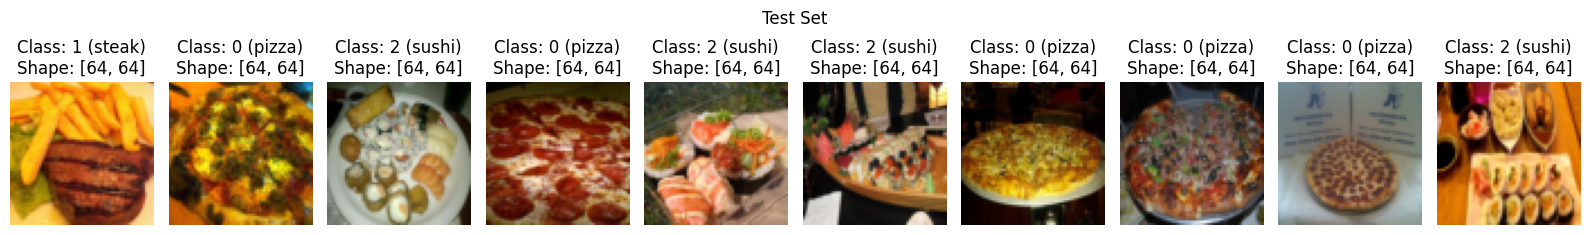

In [131]:
def display_random_images(
    dataset: torch.utils.data.dataset.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    suptitle: str = 'Dataset'
):
    # 1. Restrict the number of examples to 10
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 2. Generate random samples
    random_indices = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 3))

    # 3. Loop through the samples
    for index, sample_index in enumerate(random_indices):
        image, label = dataset[sample_index]

        # 4. Adjust image tensor shape for plotting: [channels, height, width] -> [channels, height, width]
        image = image.permute(1, 2, 0)

        # 5. Compose a explanatory title for the sample
        title = f"Class: {label} ({classes[label]})" if classes else f'Class: {label}'
        title = title + f"\nShape: {list(image.shape[:2])}" if display_shape else title

        # 6. Plot the sample
        plt.subplot(1, n, index + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
    
    plt.tight_layout()
    plt.suptitle(suptitle)

random.seed(SEED)

display_random_images(train_data_custom, classes=class_names, suptitle='Training Set')
display_random_images(test_data_custom, classes=class_names, suptitle='Test Set')

### DataLoader

#### Creation

In [138]:
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0, 
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0, 
    shuffle=True
)

print('Train DataLoader')
print('----------------')
print(f'{train_dataloader_custom}')

print('\nTest DataLoader')
print('----------------')
print(f'{test_dataloader_custom}')

Train DataLoader
----------------

Test DataLoader
----------------


#### Exploration

In [127]:
image, label = next(iter(train_dataloader_custom))

print('Image')
print('-----')
print(f'Shape: {image.shape} Type: {image.dtype}')

print('\nLabel')
print('------')
print(f'Label: {label} ({class_names[label]}) Type: {label.dtype}')

Image
-----
Shape: torch.Size([1, 3, 64, 64]) Type: torch.float32

Label
------
Label: tensor([2]) (sushi) Type: torch.int64


# TinyVGG Without Data Augmentation

## Transformations

In [150]:
simple_transform = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

## DataLoader

In [222]:
BATCH_SIZE = 32
WORKERS = os.cpu_count()

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

print(f'Batch Size: {BATCH_SIZE}')
print(f'Workers: {WORKERS}')

# Create DataLoader's
train_dataloader_simple = DataLoader(
    train_data_simple, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    test_data_simple, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print('\nTrain DataLoader')
print('----------------')
print(f'{train_dataloader_simple}')

print('\nTest DataLoader')
print('----------------')
print(f'{test_dataloader_simple}')

Batch Size: 32
Workers: 8

Train DataLoader
----------------

Test DataLoader
----------------


## Architecture

In [244]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(SEED)

input_shape, hidden_units, output_shape = 3, 10, len(train_data_simple.classes)

model_0 = TinyVGG(
    input_shape=input_shape,
    hidden_units=hidden_units,
    output_shape=output_shape
).to(DEVICE)

print('Model Architecture')
print('------------------')
print(f'{model_0} on {DEVICE}')

print('\nModel Parameters')
print(f'-------------------')
for name in model_0.state_dict().keys():
    print(f'{name}')

# for (name, param) in model_0.state_dict().items():
#     print(f'{name}: {param}')

xt = torch.randn(2, input_shape, IMG_SIZE, IMG_SIZE, device=DEVICE)
yt = model_0(xt)

print('\nInputs and Outputs')
print('-------------------')
print(f'Input: {xt}')
print(f'Output: {yt}')
print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

print('\nModel Summary')
print(model_summary(model_0, input_size=[1, 3, IMG_SIZE, IMG_SIZE]))

# model_summary() moves the model to the cpu. Move it back to the target device here.
model_0 = model_0.to(DEVICE)

Model Architecture
------------------
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
) on mps

Model Parameters
-------------------
conv_block_1.0.weight
conv_block_1.0.bias
conv_block_1.2.weight
conv_block_1.2.bias
conv_block_2.0.weight
conv_block_2.0.bias
conv_block_2.2.weight
conv_block_2.2.bias
clas

## Untrained Predictions

In [225]:
# 1. Get a batch of data
test_images_batch, test_labels_batch = next(iter(test_dataloader_simple))

# 2. Make Predictions
model_0.eval()
with torch.inference_mode():
    logits = model_0(test_images_batch.to(DEVICE))

# 3. Compute Labels
probabilities = logits.softmax(1)
y_pred = probabilities.argmax(1)

print('Untrained Predictions')
print('--------------------')
print(f'test_images_batch.shape: {test_images_batch.shape}')
print(f'test_labels_batch.shape: {test_labels_batch.shape}')
print(f'Output Shape: {untrained_preds.shape}')
print(f'Output Logits: {untrained_preds}')
print(f'Output Probabilities: {probabilities}')
print(f'Predictions: {y_pred}')
print(f'Labels: {test_labels_batch}')

Untrained Predictions
--------------------
test_images_batch.shape: torch.Size([32, 3, 64, 64])
test_labels_batch.shape: torch.Size([32])
Output Shape: torch.Size([2, 3])
Output Logits: tensor([[-0.0120,  0.0414, -0.0110],
        [-0.0147,  0.0415, -0.0113]], device='mps:0',
       grad_fn=<LinearBackward0>)
Output Probabilities: tensor([[0.3273, 0.3452, 0.3276],
        [0.3267, 0.3456, 0.3278],
        [0.3259, 0.3462, 0.3280],
        [0.3272, 0.3455, 0.3273],
        [0.3266, 0.3454, 0.3279],
        [0.3262, 0.3458, 0.3281],
        [0.3270, 0.3453, 0.3277],
        [0.3267, 0.3447, 0.3285],
        [0.3259, 0.3464, 0.3277],
        [0.3257, 0.3460, 0.3283],
        [0.3260, 0.3453, 0.3288],
        [0.3270, 0.3456, 0.3274],
        [0.3262, 0.3457, 0.3280],
        [0.3266, 0.3458, 0.3276],
        [0.3260, 0.3461, 0.3278],
        [0.3266, 0.3458, 0.3276],
        [0.3260, 0.3457, 0.3283],
        [0.3267, 0.3458, 0.3275],
        [0.3268, 0.3454, 0.3278],
        [0.3270, 0.34

## Loss Function, Optimizer and Accuracy Metrics

In [226]:
LR = 0.001

def accuracy_fn(y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_pred)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=LR, params=model_0.parameters())

## Step Functions

In [227]:
def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    ### Setup initial training state
    training_loss, training_accuracy = 0., 0.
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Send data to the appropriate device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_logits = model(X)
        y_pred = y_logits.softmax(1).argmax(1)

        # 2. Compute Loss and Accuracy
        loss = loss_fn(y_logits, y)
        accuracy = accuracy_fn(y, y_pred)

        training_loss += loss.item()
        training_accuracy += accuracy

        # 3. Clear Optimizer Gradients
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Update Weights
        optimizer.step()
    
    ### Aggregate losses and accuracies
    training_loss /= len(dataloader)
    training_accuracy /= len(dataloader)

    return training_loss, training_accuracy

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
    ### Setup epoch evaluation state
    test_loss, test_accuracy = 0., 0.
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the appropriate device
            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            y_logits = model(X)
            y_pred = y_logits.softmax(1).argmax(1)

            # 2. Compute Loss and Accuracy
            loss = loss_fn(y_logits, y)
            accuracy = accuracy_fn(y, y_pred)

            test_loss += loss.item()
            test_accuracy += accuracy
    
        ### Aggregate losses and accuracies for the test set.
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
    
    return test_loss, test_accuracy

## Training Function

In [228]:
def train(
    model: torch.nn.Module, 
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    accuracy_fn = accuracy_fn,
    device: str = DEVICE,
    epochs: int = 5
):
    
    # 1. Create a container for the results
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 2. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # 3. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 5. Return the filled results at the end of the epochs
    return results

## Loop

In [230]:
torch.manual_seed(SEED)

if DEVICE == 'mps':
    torch.mps.manual_seed(SEED)
elif DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)

EPOCHS = 5

print('Training Loop')
print('-------------')
print('-------------')

start_time = timer()

model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    epochs=EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

Training Loop
-------------
-------------


 20%|██        | 1/5 [01:02<04:08, 62.20s/it]

Epoch: 1 | train_loss: 1.1109 | train_acc: 0.2930 | test_loss: 1.1124 | test_acc: 0.2604


 40%|████      | 2/5 [02:03<03:04, 61.60s/it]

Epoch: 2 | train_loss: 1.0975 | train_acc: 0.3047 | test_loss: 1.0862 | test_acc: 0.5417


 60%|██████    | 3/5 [03:05<02:03, 61.76s/it]

Epoch: 3 | train_loss: 1.0914 | train_acc: 0.3711 | test_loss: 1.0866 | test_acc: 0.2604


 80%|████████  | 4/5 [04:06<01:01, 61.54s/it]

Epoch: 4 | train_loss: 1.0726 | train_acc: 0.4258 | test_loss: 1.0938 | test_acc: 0.2604


100%|██████████| 5/5 [05:07<00:00, 61.56s/it]

Epoch: 5 | train_loss: 1.1153 | train_acc: 0.3086 | test_loss: 1.1218 | test_acc: 0.3021
Total training time: 307.811 seconds


## Show Training Metrics

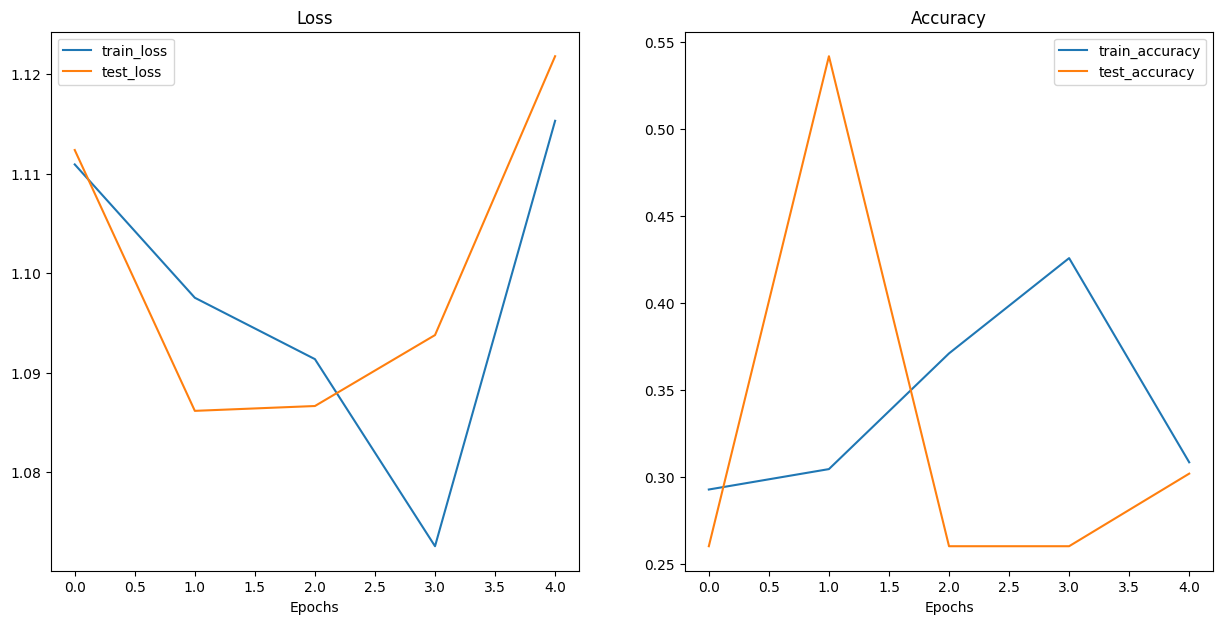

In [234]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(model_0_results)

# TinyVGG With Data Augmentation

## Transformations

We will apply augmentations using *transforms.TrivialAugmentWide()*

In [236]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Augmented Dataset

In [239]:
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform)

print('Training Set')
print('------------')
print(f'{train_data_augmented}')
print(f'Classes: {train_data_augmented.classes}')
print(f'Class Dictionary: {train_data_augmented.class_to_idx}')

print('\nTest Set')
print('------------')
print(f'{test_data_simple}')
print(f'Classes: {test_data_simple.classes}')
print(f'Class Dictionary: {test_data_simple.class_to_idx}')

Training Set
------------
Dataset ImageFolder
    Number of datapoints: 225
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}

Test Set
------------
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


## DataLoader

In [248]:
BATCH_SIZE = 32
WORKERS = os.cpu_count()

print(f'Batch Size: {BATCH_SIZE}')
print(f'Workers: {WORKERS}')

# Create DataLoader's
train_dataloader_augmented = DataLoader(
    train_data_augmented, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    test_data_simple, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print('\nTrain DataLoader')
print('----------------')
print(f'{train_dataloader_augmented}')

print('\nTest DataLoader')
print('----------------')
print(f'{test_dataloader_simple}')

Batch Size: 32
Workers: 8

Train DataLoader
----------------

Test DataLoader
----------------


## Architecture

In [249]:
torch.manual_seed(SEED)

input_shape, hidden_units, output_shape = 3, 10, len(train_data_augmented.classes)

model_1 = TinyVGG(
    input_shape=input_shape,
    hidden_units=hidden_units,
    output_shape=output_shape
).to(DEVICE)

print('Model Architecture')
print('------------------')
print(f'{model_1} on {DEVICE}')

print('\nModel Parameters')
print(f'-------------------')
for name in model_1.state_dict().keys():
    print(f'{name}')

# for (name, param) in model_0.state_dict().items():
#     print(f'{name}: {param}')

xt = torch.randn(2, input_shape, IMG_SIZE, IMG_SIZE, device=DEVICE)
yt = model_1(xt)

print('\nInputs and Outputs')
print('-------------------')
print(f'Input: {xt}')
print(f'Output: {yt}')
print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

print('\nModel Summary')
print(model_summary(model_1, input_size=[1, 3, IMG_SIZE, IMG_SIZE]))

# model_summary() moves the model to the cpu. Move it back to the target device here.
model_1 = model_1.to(DEVICE)

Model Architecture
------------------
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
) on mps

Model Parameters
-------------------
conv_block_1.0.weight
conv_block_1.0.bias
conv_block_1.2.weight
conv_block_1.2.bias
conv_block_2.0.weight
conv_block_2.0.bias
conv_block_2.2.weight
conv_block_2.2.bias
clas

## Loop

In [250]:
torch.manual_seed(SEED)

if DEVICE == 'mps':
    torch.mps.manual_seed(SEED)
elif DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)

EPOCHS = 5

print('Training Loop')
print('-------------')
print('-------------')

start_time = timer()

model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    epochs=EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

Training Loop
-------------
-------------


 20%|██        | 1/5 [01:01<04:05, 61.36s/it]

Epoch: 1 | train_loss: 1.1012 | train_acc: 0.2930 | test_loss: 1.1057 | test_acc: 0.1979


 40%|████      | 2/5 [02:02<03:04, 61.44s/it]

Epoch: 2 | train_loss: 1.1016 | train_acc: 0.2930 | test_loss: 1.1057 | test_acc: 0.1979


 60%|██████    | 3/5 [03:03<02:02, 61.25s/it]

Epoch: 3 | train_loss: 1.1018 | train_acc: 0.2930 | test_loss: 1.1057 | test_acc: 0.1979


 80%|████████  | 4/5 [04:05<01:01, 61.25s/it]

Epoch: 4 | train_loss: 1.1024 | train_acc: 0.2930 | test_loss: 1.1057 | test_acc: 0.1979


100%|██████████| 5/5 [05:05<00:00, 61.19s/it]

Epoch: 5 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1057 | test_acc: 0.1979
Total training time: 305.936 seconds
